[[-5.54787614e-01 -4.47213590e-01  3.91760720e+02]
 [-4.17768101e-01 -3.63095823e-01  3.05973435e+02]
 [-1.40942688e-03 -1.14590702e-03  1.00000000e+00]]
Number of inliers: 156


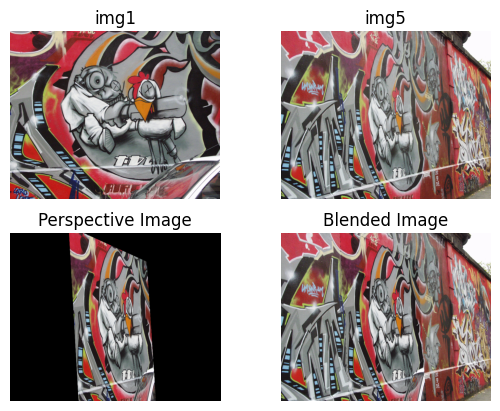

In [2]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# detect SIFT features
def findFeatures(img):
    sift = cv.SIFT_create()
    key, des = sift.detectAndCompute(img, None)
    return key, des

# find feature matches using BFMatcher
def findMatches(des1, des5):
    bf = cv.BFMatcher()
    matches = bf.knnMatch(des1, des5, k=2)
    return matches

# Homography calculation 
def calHomography(sample):
    A = []
    for i in range(len(sample)):
        x1, y1, x2, y2 = sample[i, 0], sample[i, 1], sample[i, 2], sample[i, 3]
        A.append([-x1, -y1, -1, 0, 0, 0, x2*x1, x2*y1, x2])
        A.append([0, 0, 0, -x1, -y1, -1, y2*x1, y2*y1, y2])

    A = np.matrix(A)
    U, S, V = np.linalg.svd(A)
    H = np.reshape(V[-1], (3, 3))
    H = (1/H.item(8)) * H
    return H

def calDistance(H, correspondence):
    p1 = np.transpose(np.matrix([correspondence[0].item(0), correspondence[0].item(1), 1]))
    estimatep2 = np.dot(H, p1)
    estimatep2 = (1 / estimatep2.item(2)) * estimatep2

    p2 = np.transpose(np.matrix([correspondence[0].item(2), correspondence[0].item(3), 1]))
    error = p2 - estimatep2
    return np.linalg.norm(error)

# RANSAC algorithm-robust homography
def RANSAC(corres, threshold):
    max_inliers = []
    homography = []

    for _ in range(int(np.log(1 - 0.95) / np.log(1 - (1 - 0.5) ** 4))):
        sample = np.vstack([corres[np.random.randint(0, len(corres))] for _ in range(4)])
        h = calHomography(sample)
        inliers = []

        for j in range(len(corres)):
            distance = calDistance(h, corres[j])
            if distance < threshold:
                inliers.append(corres[j])

        if len(inliers) > len(max_inliers):
            max_inliers = inliers
            homography = h

    return homography, inliers

# Load images
img1 = cv.imread('graf/img1.ppm')
img5 = cv.imread('graf/img5.ppm')

# Detect and match features
estimated_threshold = 100
key1, des1 = findFeatures(img1)
key5, des5 = findFeatures(img5)
matches = findMatches(des1, des5)

# Store correspondences
correspondence = []
for match in matches:
    (x1, y1) = key1[match[0].queryIdx].pt
    (x2, y2) = key5[match[0].trainIdx].pt
    correspondence.append([x1, y1, x2, y2])

corres = np.matrix(correspondence)

# compute homography
H, inliers = RANSAC(corres, estimated_threshold)
print(H)
print('Number of inliers:', len(inliers))

# Display original images
plt.subplot(2, 2, 1)
plt.imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
plt.title('img1')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(cv.cvtColor(img5, cv.COLOR_BGR2RGB))
plt.title('img5')
plt.axis('off')

with open('graf/H1to5p', 'r') as h_text:
    original_H = np.matrix([list(map(float, line.split())) for line in h_text])

image_perspective = cv.warpPerspective(img1, original_H, (img5.shape[1], img5.shape[0]))

plt.subplot(2, 2, 3)
plt.imshow(cv.cvtColor(image_perspective, cv.COLOR_BGR2RGB))
plt.title('Perspective Image')
plt.axis('off')

threshold, mask = cv.threshold(cv.cvtColor(image_perspective, cv.COLOR_BGR2GRAY), 1, 255, cv.THRESH_BINARY)
mask_inv = cv.bitwise_not(mask)
img5_bg = cv.bitwise_and(img5, img5, mask=mask_inv)
dst = cv.addWeighted(img5_bg, 1, image_perspective, 1, 0)

plt.subplot(2, 2, 4)
plt.imshow(cv.cvtColor(dst, cv.COLOR_BGR2RGB))
plt.title('Blended Image')
plt.axis('off')
plt.show()


((< cv2.DMatch 00000186F8C10730>, < cv2.DMatch 00000186E83D59D0>), (< cv2.DMatch 00000186F8AD4B90>, < cv2.DMatch 00000186F8AD5270>), (< cv2.DMatch 0000018680D2CDB0>, < cv2.DMatch 0000018680D2CF10>), (< cv2.DMatch 0000018680D2E030>, < cv2.DMatch 0000018680D2D570>), (< cv2.DMatch 0000018680D2FF90>, < cv2.DMatch 0000018680D2EDB0>))


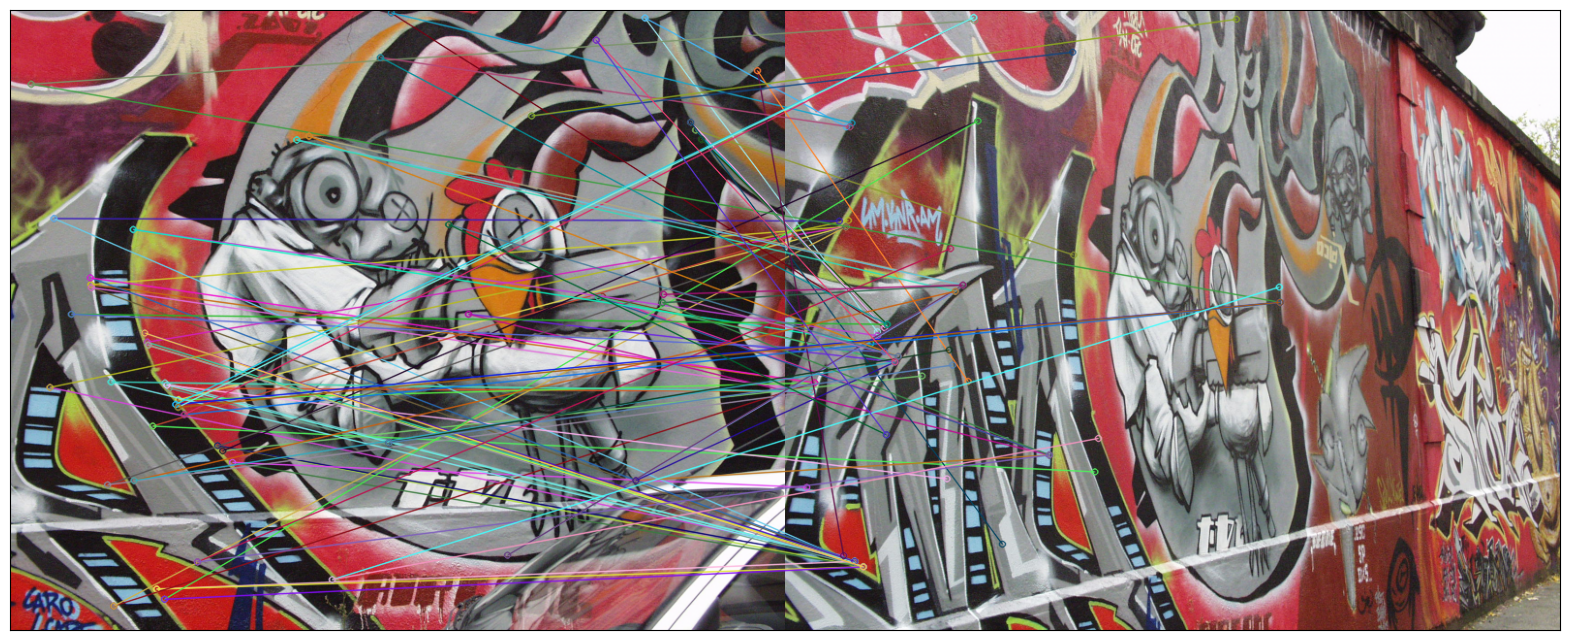

In [5]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt


image1_gray = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
image5_gray = cv.cvtColor(img5, cv.COLOR_BGR2GRAY)
image1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
image5 = cv.cvtColor(img5, cv.COLOR_BGR2RGB)

sift = cv.SIFT_create()
bf_matcher = cv.BFMatcher()

keypoints1, descriptors1 = sift.detectAndCompute(image1_gray, None)
keypoints5, descriptors5 = sift.detectAndCompute(image5_gray, None)

# KNN matching
matches = bf_matcher.knnMatch(descriptors1, descriptors5, k=2)
print(matches[:5])  

matches = sorted(matches, key=lambda x: x[0].distance)

output_image = cv.drawMatchesKnn(image1, keypoints1, image5, keypoints5, matches[:50], image5, flags=2)

# plot
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(output_image)
ax.set_xticks([])  
ax.set_yticks([])  

plt.show()
